# ELO System for Football (2014 - 2020)

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1, rc={
    'figure.figsize': (15, 10),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#333333',
    'xtick.color': '#666666',
    'ytick.color': '#666666'
})

from datetime import datetime

In [2]:
df = pd.read_csv('Football Database\\games.csv')
df = df.sort_values(by='date')
df

,gameID,leagueID,season,date,homeTeamID,awayTeamID,homeGoals,awayGoals,homeProbability,drawProbability,...,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA
5437,6185,5,2014,2014-08-08 19:30:00,177,161,2,2,0.1036,0.1950,...,1.37,9.00,4.5,1.36,10.50,4.80,1.36,10.55,5.17,1.37
5443,6191,5,2014,2014-08-09 20:00:00,168,210,1,0,0.6216,0.3219,...,4.36,2.05,3.1,4.00,2.05,3.30,4.20,1.85,3.51,5.15
5444,6192,5,2014,2014-08-09 20:00:00,170,174,3,2,0.5335,0.2564,...,2.85,2.80,2.9,2.80,2.75,3.10,2.90,3.01,3.31,2.58
5442,6190,5,2014,2014-08-09 20:00:00,166,176,0,1,0.4117,0.3367,...,3.29,2.50,3.0,3.00,2.50,3.10,3.25,2.82,3.06,2.95
5440,6188,5,2014,2014-08-09 20:00:00,169,175,0,2,0.0911,0.2592,...,2.41,3.10,3.1,2.40,3.40,3.10,2.40,3.25,3.02,2.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12672,16128,5,2020,2021-05-23 19:00:00,210,171,0,0,0.0576,0.2716,...,1.62,4.80,4.0,1.65,5.00,4.10,1.60,5.56,4.62,1.59
12671,16127,5,2020,2021-05-23 19:00:00,241,161,0,2,0.0485,0.1570,...,1.27,11.00,6.0,1.25,9.50,6.00,1.25,9.75,8.07,1.24
12670,16126,5,2020,2021-05-23 19:00:00,167,160,1,2,0.1192,0.2552,...,1.36,9.50,4.6,1.35,9.00,4.75,1.33,7.91,5.08,1.42
12673,16129,5,2020,2021-05-23 19:00:00,178,170,2,3,0.3071,0.2876,...,14.25,1.20,6.5,13.00,1.18,7.00,13.00,1.21,8.19,12.61


In [3]:
team_names = pd.read_csv('Football Database\\teams.csv')
team_names

,teamID,name
0,71,Aston Villa
1,72,Everton
2,74,Southampton
3,75,Leicester
4,76,West Bromwich Albion
...,...,...
141,182,Nancy
142,224,Amiens
143,225,Strasbourg
144,235,Nimes


In [7]:
# Create a dictionary to store the ELO ratings for each team
elo = {}

# Create a dictionary to store the ELO ratings for each team for plotting over time
elo_over_time = {}

# Set the starting ELO rating for all teams
starting_elo = 1000

# Set how much the ELO decays over time (0.05 = 5% decay per year)
elo_decay_rate = 0.05

# Set the K-factor for the ELO rating system
attack_k_factor = 10
defense_k_factor = 5

# Iterate through the games in the dataset
for i, row in df.iterrows():
    home_team = row['homeTeamID']
    away_team = row['awayTeamID']
    home_goals = row['homeGoals']
    away_goals = row['awayGoals']
    date = datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')
    
    # Initialize the ELO ratings for the teams if they do not exist
    if home_team not in elo:
        elo[home_team] = {'attack': starting_elo, 'defense': starting_elo, 'last_update': date}
        elo_over_time[home_team] = {'attack': [(date, starting_elo)], 'defense': [(date, starting_elo)]}
    if away_team not in elo:
        elo[away_team] = {'attack': starting_elo, 'defense': starting_elo, 'last_update': date}
        elo_over_time[away_team] = {'attack': [(date, starting_elo)], 'defense': [(date, starting_elo)]}

    
    # Calculate the ELO decay for each team
    home_time_since_last_update = (date - elo[home_team]['last_update']).days
    away_time_since_last_update = (date - elo[away_team]['last_update']).days

    if 'home_attack_elo' in globals():
        home_attack_elo = home_attack_elo * (1 - elo_decay_rate) ** (home_time_since_last_update/365)
        home_defense_elo = home_defense_elo * (1 - elo_decay_rate) ** (home_time_since_last_update/365)

    if 'away_attack_elo' in globals():
        away_attack_elo = away_attack_elo * (1 - elo_decay_rate) ** (away_time_since_last_update/365)
        away_defense_elo = away_defense_elo * (1 - elo_decay_rate) ** (away_time_since_last_update/365)

    # Update the 'last_update' as it has been updated
    elo[home_team]['last_update'] = date
    elo[away_team]['last_update'] = date

    # Calculate the expected scores for each team
    home_attack_elo = elo[home_team]['attack']
    away_defense_elo = elo[away_team]['defense']
    home_expected_score = 1 / (1 + 10 ** ((away_defense_elo - home_attack_elo) / 400))
    
    away_attack_elo = elo[away_team]['attack']
    home_defense_elo = elo[home_team]['defense']
    away_expected_score = 1 / (1 + 10 ** ((home_defense_elo - away_attack_elo) / 400))
    
    # Update the ELO ratings for the teams based on the actual scores
    home_attack_elo += attack_k_factor * (home_goals - home_expected_score)
    home_defense_elo += defense_k_factor * (away_expected_score - away_goals)
    
    away_attack_elo += attack_k_factor * (away_goals - away_expected_score)
    away_defense_elo += defense_k_factor * (home_expected_score - home_goals)

    # Ensure the ELO ratings do not go negative (ELO Floor)
    if home_defense_elo < 0:
        home_defense_elo = 0
    if away_defense_elo < 0:
        away_defense_elo = 0
    if home_attack_elo < 0:
        home_attack_elo = 0

    elo[home_team]['attack'] = home_attack_elo
    elo[home_team]['defense'] = home_defense_elo
    elo[away_team]['attack'] = away_attack_elo
    elo[away_team]['defense'] = away_defense_elo

    # store the ELO ratings over time for each team
    elo_over_time[home_team]['attack'].append((date, home_attack_elo))
    elo_over_time[home_team]['defense'].append((date, home_defense_elo))
    elo_over_time[away_team]['attack'].append((date, away_attack_elo))
    elo_over_time[away_team]['defense'].append((date, away_defense_elo))


# Print the final ELO ratings for each team
for team, ratings in elo.items():
    print(f'Team {team} - Attack: {ratings["attack"]:.2f}, Defense: {ratings["defense"]:.2f}')

Team 177 - Attack: 1381.47, Defense: 642.84
Team 161 - Attack: 4954.59, Defense: 1049.26
Team 168 - Attack: 1442.97, Defense: 591.27
Team 210 - Attack: 1269.33, Defense: 745.94
Team 170 - Attack: 1996.37, Defense: 621.41
Team 174 - Attack: 1268.60, Defense: 361.77
Team 166 - Attack: 1905.67, Defense: 543.58
Team 176 - Attack: 1801.90, Defense: 549.61
Team 169 - Attack: 1425.05, Defense: 407.69
Team 175 - Attack: 1742.76, Defense: 626.47
Team 209 - Attack: 1155.22, Defense: 829.37
Team 165 - Attack: 1172.69, Defense: 471.22
Team 162 - Attack: 1141.78, Defense: 759.01
Team 164 - Attack: 2689.06, Defense: 648.38
Team 160 - Attack: 2000.15, Defense: 806.93
Team 180 - Attack: 1261.12, Defense: 371.39
Team 178 - Attack: 3502.58, Defense: 708.45
Team 163 - Attack: 1856.63, Defense: 671.16
Team 171 - Attack: 3168.41, Defense: 649.88
Team 179 - Attack: 1524.90, Defense: 445.43
Team 89 - Attack: 2822.22, Defense: 835.19
Team 84 - Attack: 1289.57, Defense: 540.73
Team 81 - Attack: 2157.35, Defens

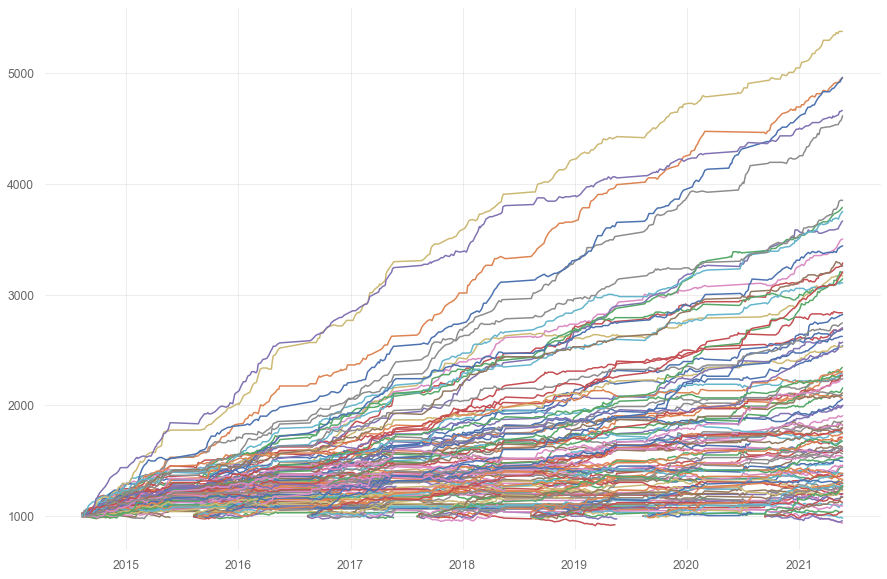

In [8]:
# Plot the ELO ratings over time for each team
for team in elo_over_time:
    plt.plot([date for date, elo in elo_over_time[team]['attack']], [elo for date, elo in elo_over_time[team]['attack']], label=f'{team} attack')

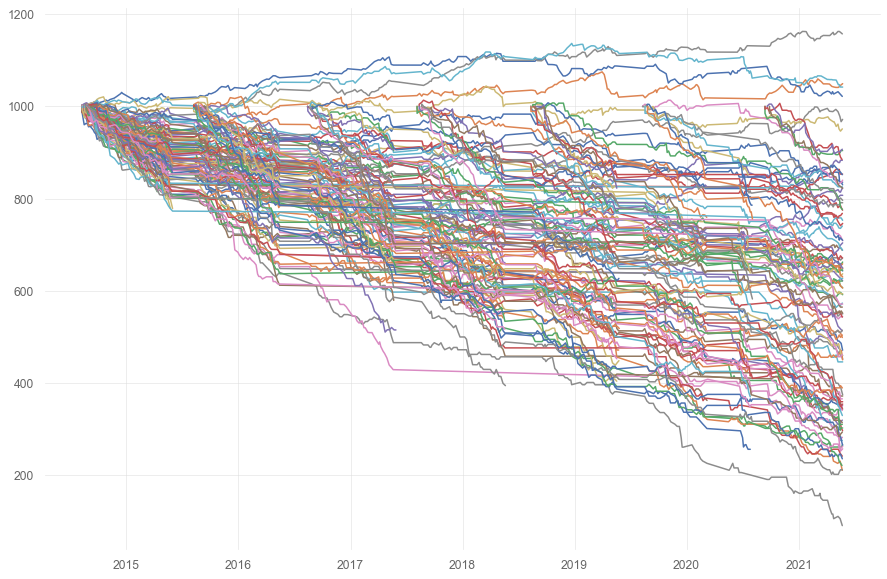

In [9]:
for team in elo_over_time:
    plt.plot([date for date, elo in elo_over_time[team]['defense']], [elo for date, elo in elo_over_time[team]['defense']], label=f'{team} defense')

In [12]:
# Create an empty dictionary to store the overall ELO ratings for each team
overall_elo = {}

# Iterate through the teams and calculate the overall ELO rating
for team, ratings in elo.items():
    overall_elo[team] = (ratings["attack"] * ratings["defense"]) / 2000 

# Order the dictionary by overall ELO rating in descending order
overall_elo = {k: v for k, v in sorted(overall_elo.items(), key=lambda item: item[1], reverse=True)}

# Print the overall ELO ratings for each team
for team, rating in overall_elo.items():
    print(f'{team} {team_names.loc[team_names.teamID == team].name.values[0]} - Overall: {rating:.0f}')

161 Paris Saint Germain - Overall: 2599
148 Barcelona - Overall: 2557
117 Bayern Munich - Overall: 2535
88 Manchester City - Overall: 2242
150 Real Madrid - Overall: 2059
98 Juventus - Overall: 1954
143 Atletico Madrid - Overall: 1588
105 Napoli - Overall: 1523
87 Liverpool - Overall: 1509
106 Inter - Overall: 1367
82 Tottenham - Overall: 1273
178 Lyon - Overall: 1241
95 Roma - Overall: 1220
89 Manchester United - Overall: 1179
129 Borussia Dortmund - Overall: 1176
80 Chelsea - Overall: 1169
136 RasenBallsport Leipzig - Overall: 1117
83 Arsenal - Overall: 1040
171 Monaco - Overall: 1030
107 Atalanta - Overall: 969
111 AC Milan - Overall: 904
96 Lazio - Overall: 898
164 Marseille - Overall: 872
160 Lille - Overall: 807
138 Sevilla - Overall: 805
119 Bayer Leverkusen - Overall: 769
154 Villarreal - Overall: 761
130 Borussia M.Gladbach - Overall: 693
146 Valencia - Overall: 653
163 Rennes - Overall: 623
170 Nice - Overall: 620
147 Athletic Club - Overall: 604
75 Leicester - Overall: 597
1